# Embrace Processing

Preprocessing for Embrace: Resampled csv's from other two notebooks

In [1]:
# %pylab inline
from joblib import load
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import math

In [2]:
# check if a value is nan: if nan, return false, otherwise, true.

def nnan(x):
    try:
        if math.isnan(x):
            return False
        else:
            return True
    except:
        return True

In [3]:
# Take a dataframe & two codes, find indices where annotations change from a1 to a2. Return array.
def isoannos(df, anchange, a1, a2):
    change = np.array([])
    for i in anchange[0][1:]:
        if (df["anno"][i] == a2) & (df["anno"][i - 1] == a1):
            # print(i, df["anno"][i], i-1, df["anno"][i-1])
            change = np.append(change, i)
    try: 
        return change[1:]
    except: # CATCH AN EXPLICIT ERROR, BUT TRY NOT TO USE TRY/EXCEPT WHEN POSSIBLE
        return change

In [4]:
# Expand array (from isoannos). Returns array of arrays of n numbers before and after each number in arr.
def exarr(arr, n):
    full = np.array([])
    for i in arr:
        full = np.append(full, np.array(range(int(i) - n, int(i) + n)))
    return full

In [5]:
# Normalize. Takes data, divides by largest magnitude number, subtracts mean value from all values
# TODO: Order seems to matter -- which one is best, a or b? A seems more true to what we want
def normdata(data):
    data = data - np.mean(data)
    data = data/np.max(np.abs(data))
    return data

# b = d/max(abs(d))
# b = b - np.array(b)[0]
# a = d - np.array(d)[0]
# a = a / max(abs(a))

In [6]:
# Find delta values: Take a series of numbers, subtract the first value from the next
# Use np.diff instead

def delta(data):
    f = data - np.roll(data, 1)
    return f

In [7]:
# RMS
# TODO: I think there's a built-in function for this in math linalg
# REname to use accelerometer dimensions
def RMS(d1, d2, d3):
    f = np.sqrt(d1**2 + d2**2 + d3**2)
    return f

In [8]:
# TODO: Comment please
def createdata(z, annochange, changefrom, changeto, surround):
    y = isoannos(z, annochange, changefrom, changeto)
    final = exarr(y, surround)
    final = final.reshape(len(y), 2 * surround)
    return final

In [9]:
# TODO: Comment please
# TODO: This was something of a mistake. Maybe keep it as a cell?
def preprocess(patient_code, frequency):
    
    # Read csv
    x = pd.read_csv("{f}_{c}.csv".format(f = frequency, c = patient_code))
    
    # replace all Nan values with most recent annotated value
    for i in range(len(x["anno"])):
        if not nnan(x["anno"][i]):
            x.set_value(i, "anno", x["anno"][i-1])
    
    # find locations of change
    annochange = np.where((x != pd.DataFrame.shift(x, 1))["anno"])
    
    # Recode annotations
    # Recoding: 0 = still, 1 = slow, 2 = moderate, 3 = vigorous, 4 = unknown, START

    remap = {'still': 0, 'slow': 1, 'moderate': 2, 'vigorous': 3, 'unknown':4, 'START':4}
    keys = ["still", "slow", "mod", "vig"]
    z = x.replace(remap, inplace=False)
    return (z, x, annochange)

In [44]:
# TODO: comment please
def process(patient_code, frequency, surround, z, x, annochange):
    keys = ["still", "slow", "mod", "vig"]
    
    # Define transitions
    trans_combos = (np.array([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 2), (3, 1), (3, 0), (2, 1), (2, 0), (1, 0)]))
    
    cw= plt.get_cmap('Set1')
    colors = cw(np.array([0, 1]))
    f=plt.figure(figsize=(15, 15))
    count = 1
    for i in trans_combos:
        ax = f.add_subplot(4, 3, count)
        dRMS_line = plt.plot(0, 0)
        EDA_line = plt.plot(0, 0)
        changefrom = i[0]
        changeto = i[1]
        final = createdata(z, annochange, changefrom, changeto, surround)
        for j in range(len(final)):
            r = np.diff(RMS(np.diff(x.X[final[j]]), np.diff(x.Y[final[j]]), np.diff(x.Z[final[j]])))
            dRMS_line = ax.plot(range(-surround, surround - 2), normdata(r), color=colors[0], label = 'dRMS')
            EDA_line = ax.plot(range(-surround, surround - 1), np.diff(normdata(x.eda_microsiemens[final[j]])), color=colors[1], label = 'EDA')
        ax.axvline(x=0, color='black')
        ax.set_title('{k1}-{k2}'.format(k1 = keys[changefrom], k2 = keys[changeto]))
        # ax.legend(handles=[dRMS_line[0], EDA_line[0]])
        count = count + 1
            
    plt.figlegend((dRMS_line[0], EDA_line[0]), ("dRMS", "EDA"), "best")
       # hL = plt.subplot(4,4,14.5);
        #poshL = hL.get_position()

        #lgd = plt.legend(handles=[dRMS_line[0], EDA_line[0]]);
        #lgd.set_position(poshL)
    plt.suptitle("{c}, {k1}-{k2}, delta-RMS and delta-EDA vs. time".format(c = patient_code, k1 = keys[changefrom], k2 = keys[changeto]))
    plt.show()
    f.savefig("DIA_{c}_embrace_acc+eda_{t}s_RMSderiv.png".format(\
            c = patient_code, t = 2*surround))

In [41]:
# Patient codes of files to read
patients = ["9W3WM", "C3LMM", "GLDRM", "KVNJM", "NBFLM", "R82RM", "SGFHM",\
            "2A6XM", "D54QM", "FRV5M", "GMQFM", "HWJDM","QNF9M", "ZRAMM"]
# Frequency of files to read
frequency = "1s"
patient_code = "9W3WM"

# TODOS

First, all TODOs in code

Second: measure StdDevs so that ranges from -3 to +3, rather than -1 to +1?


/Users/Joanna/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/Joanna/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:338: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


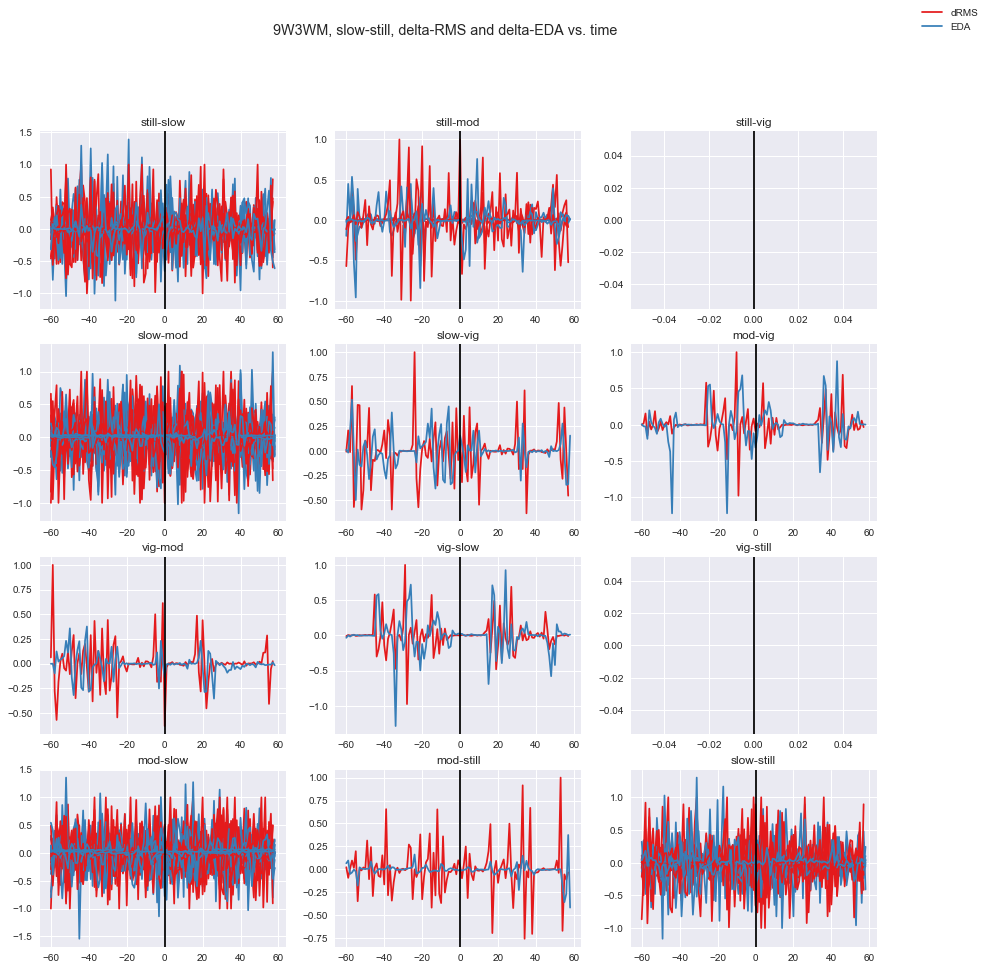

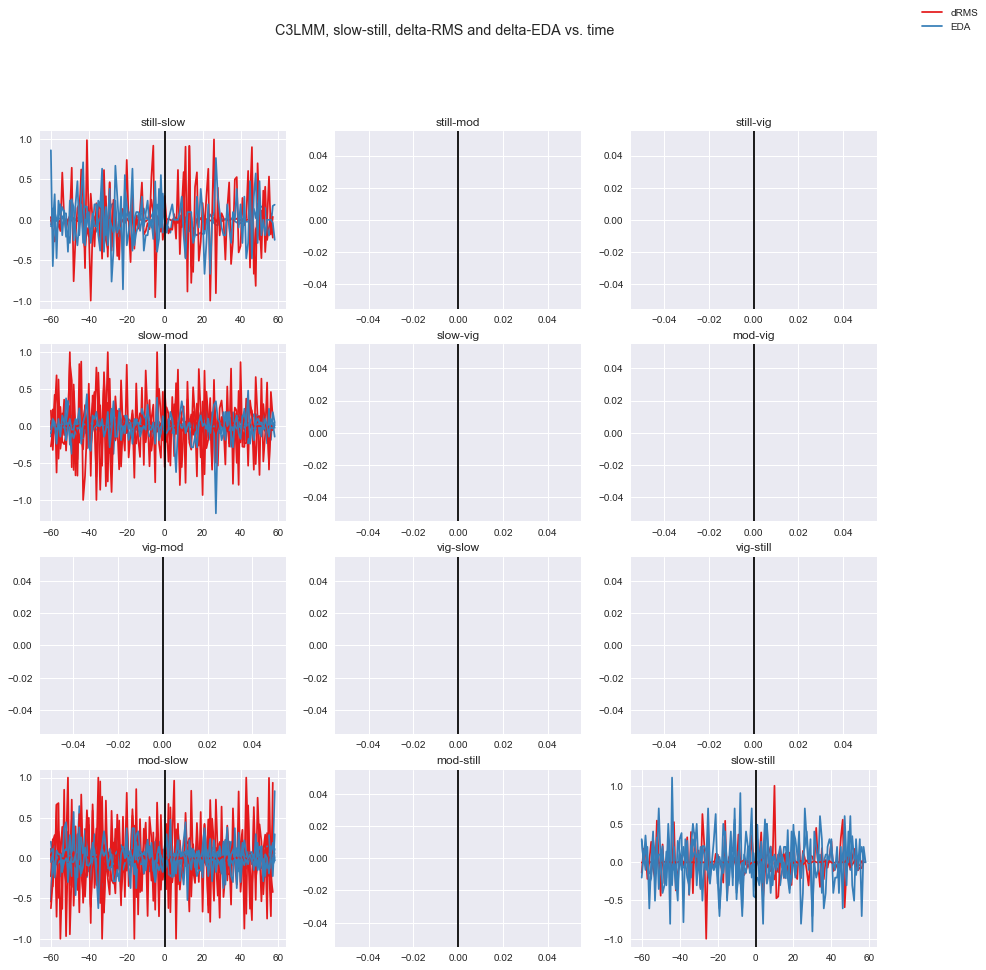

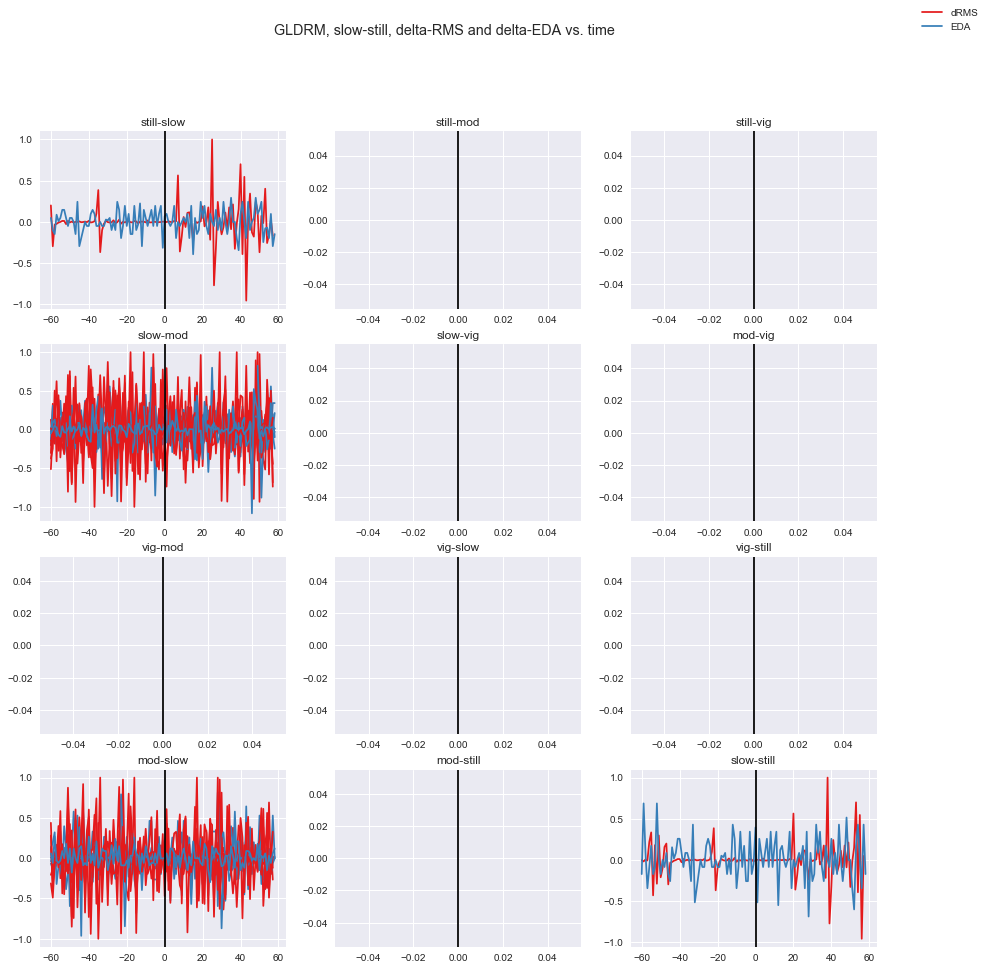

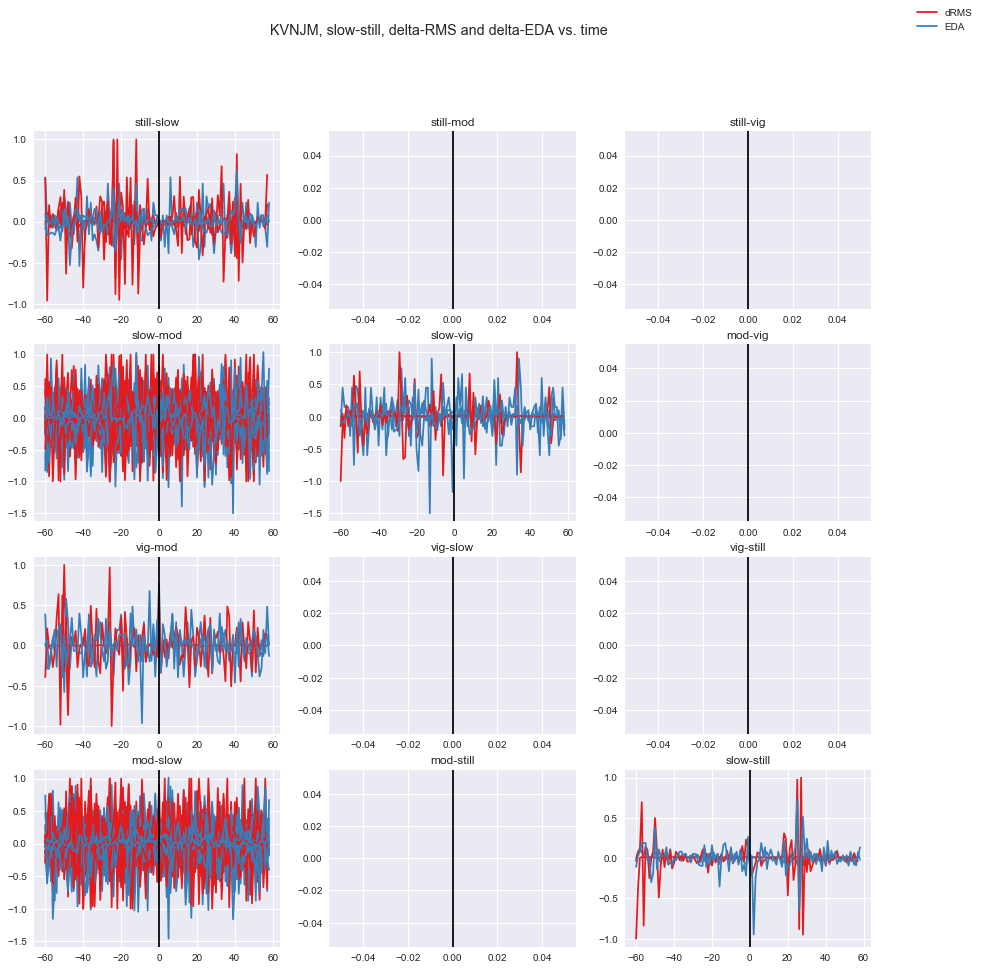

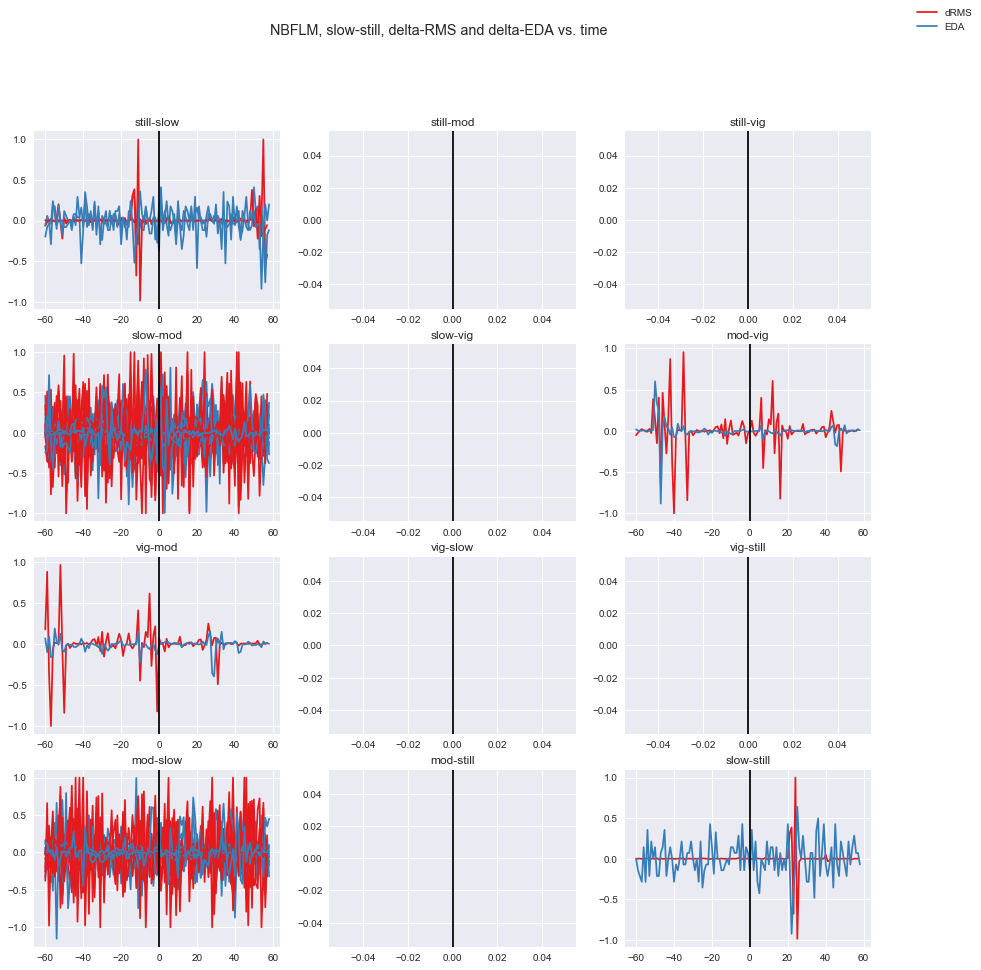

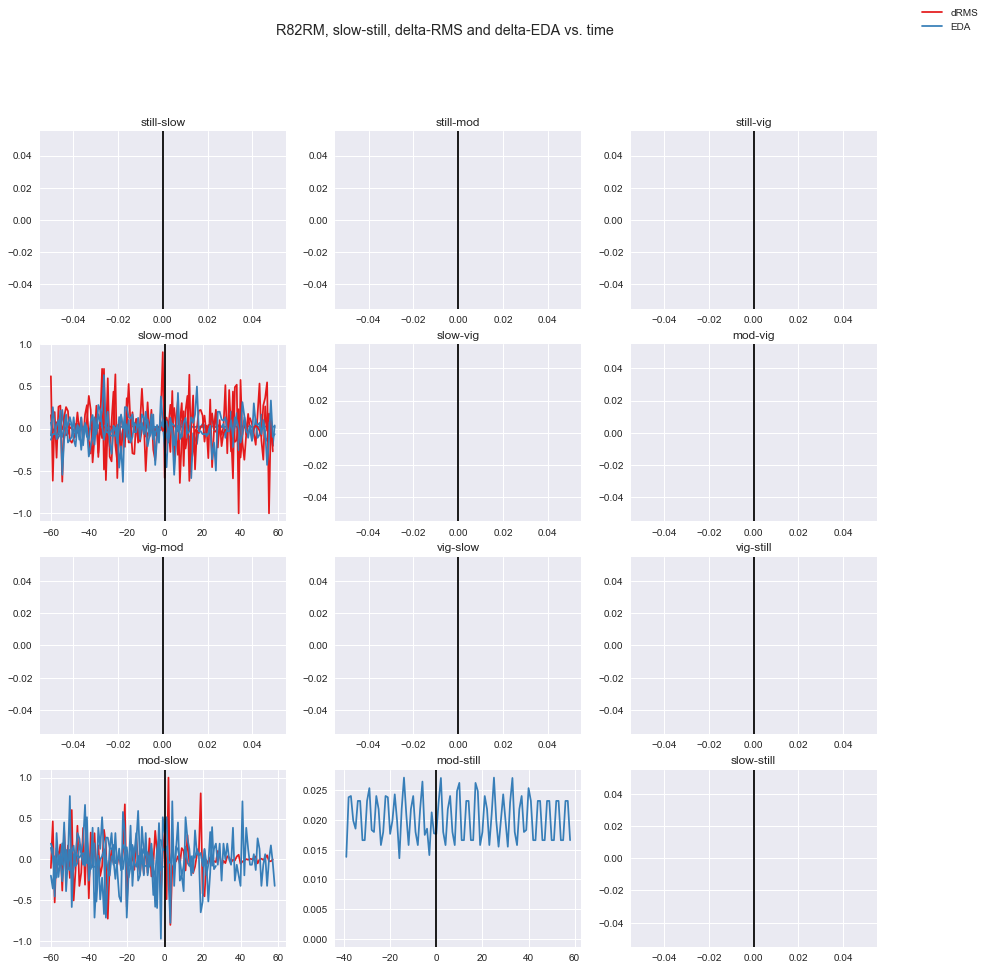

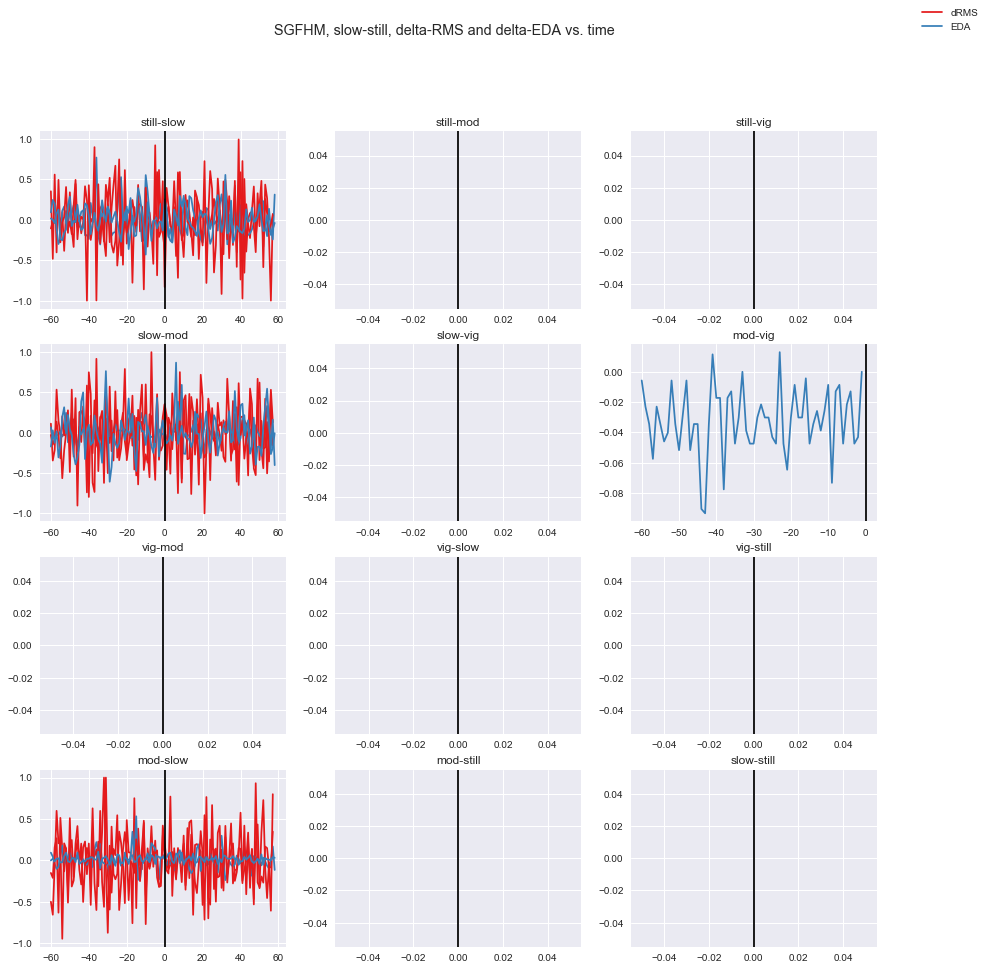

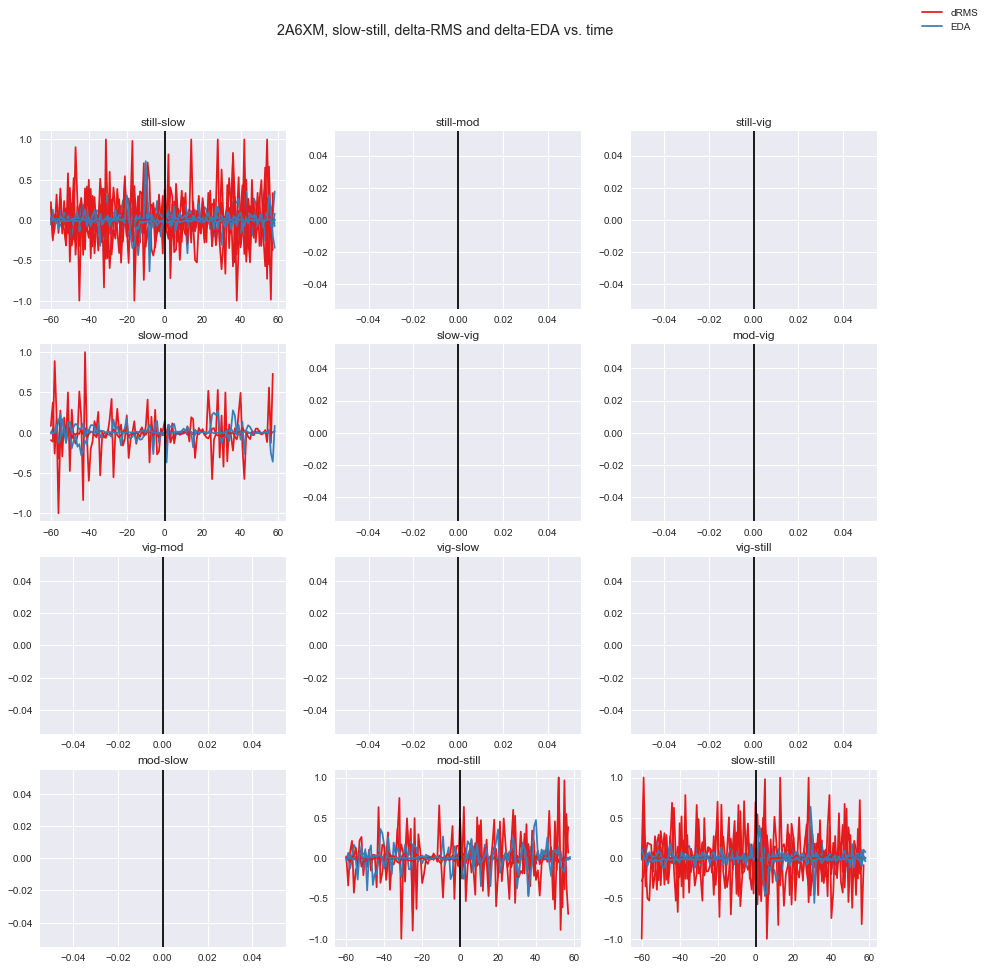

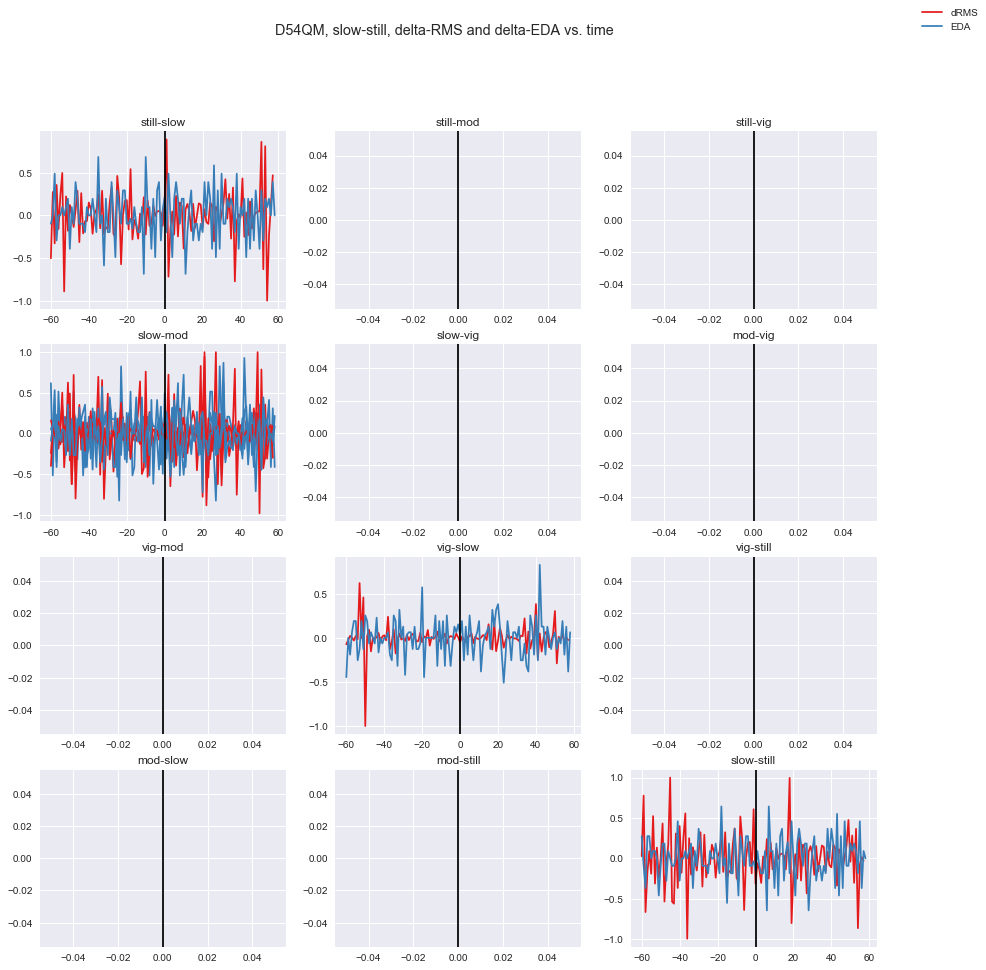

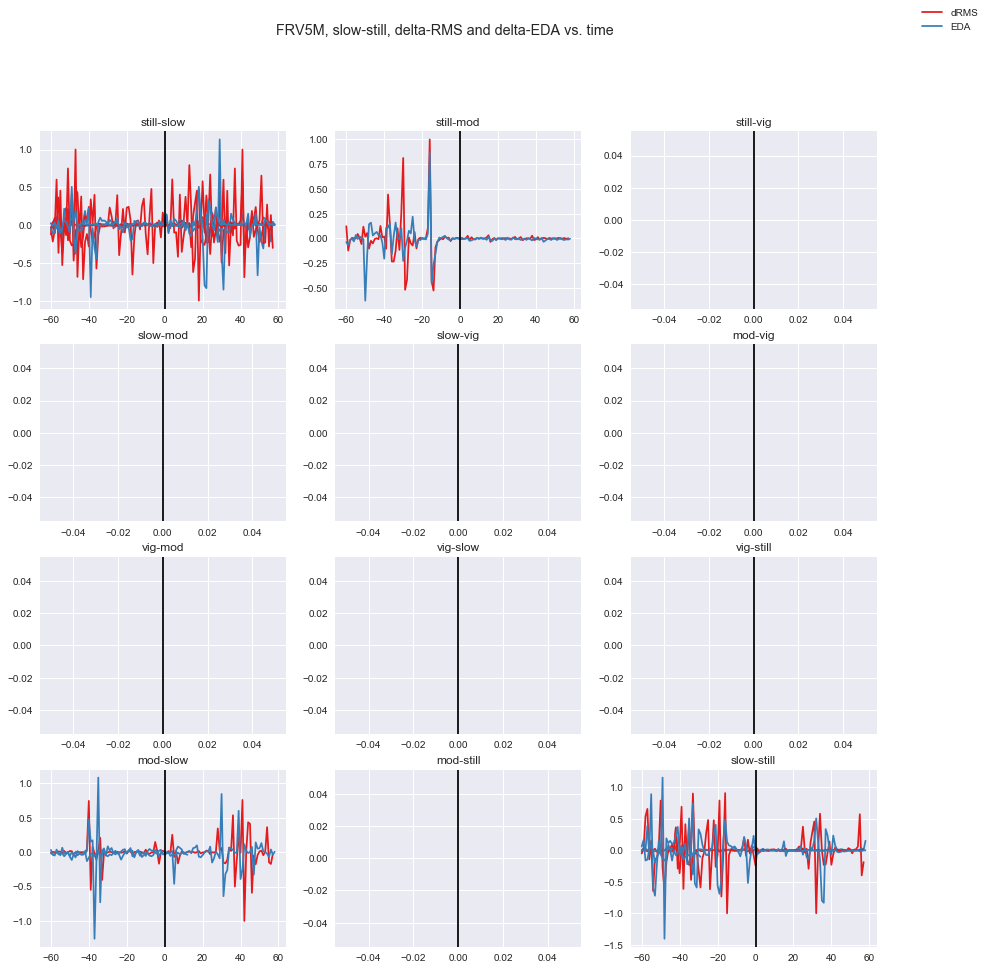

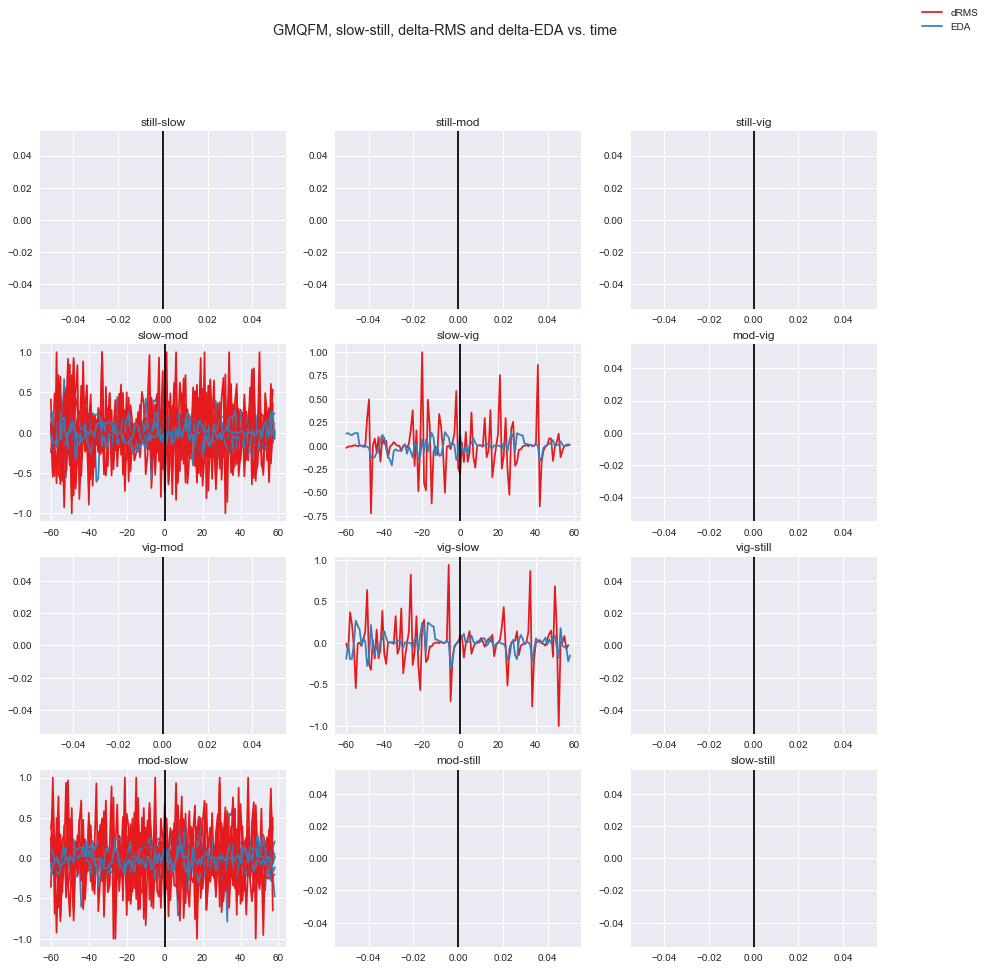

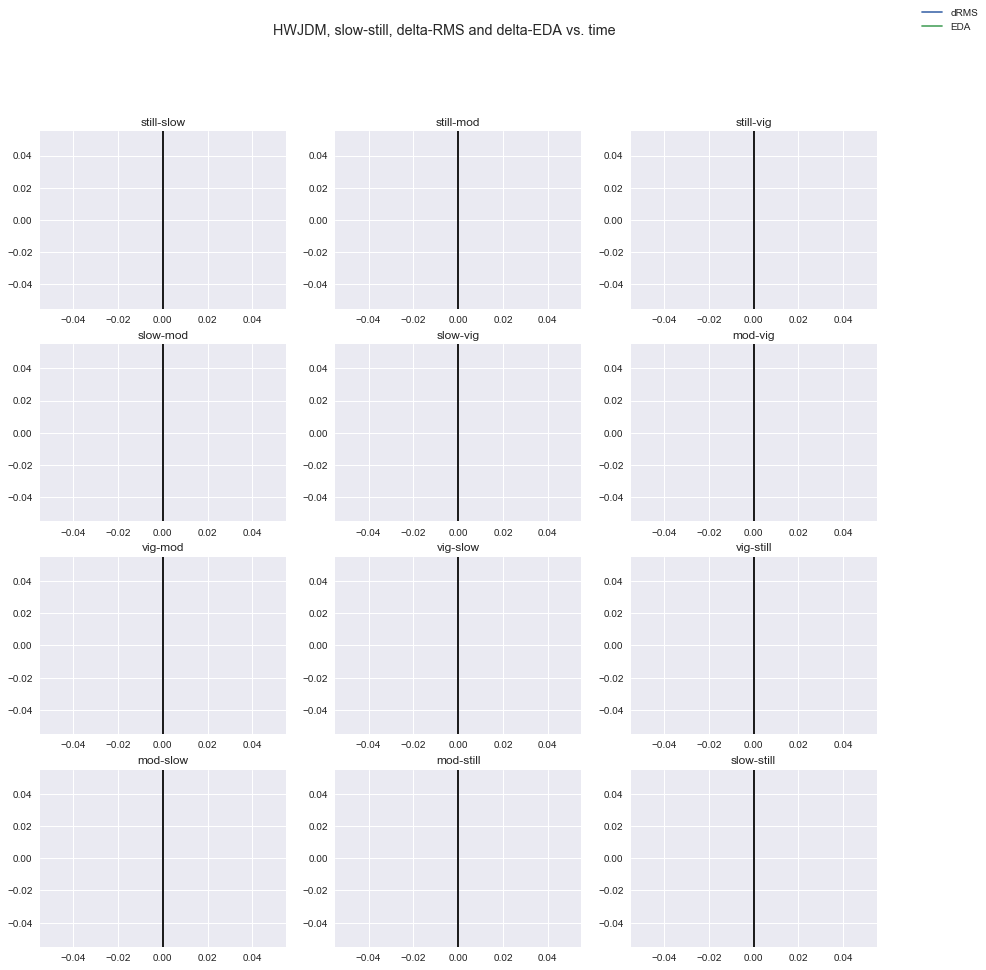

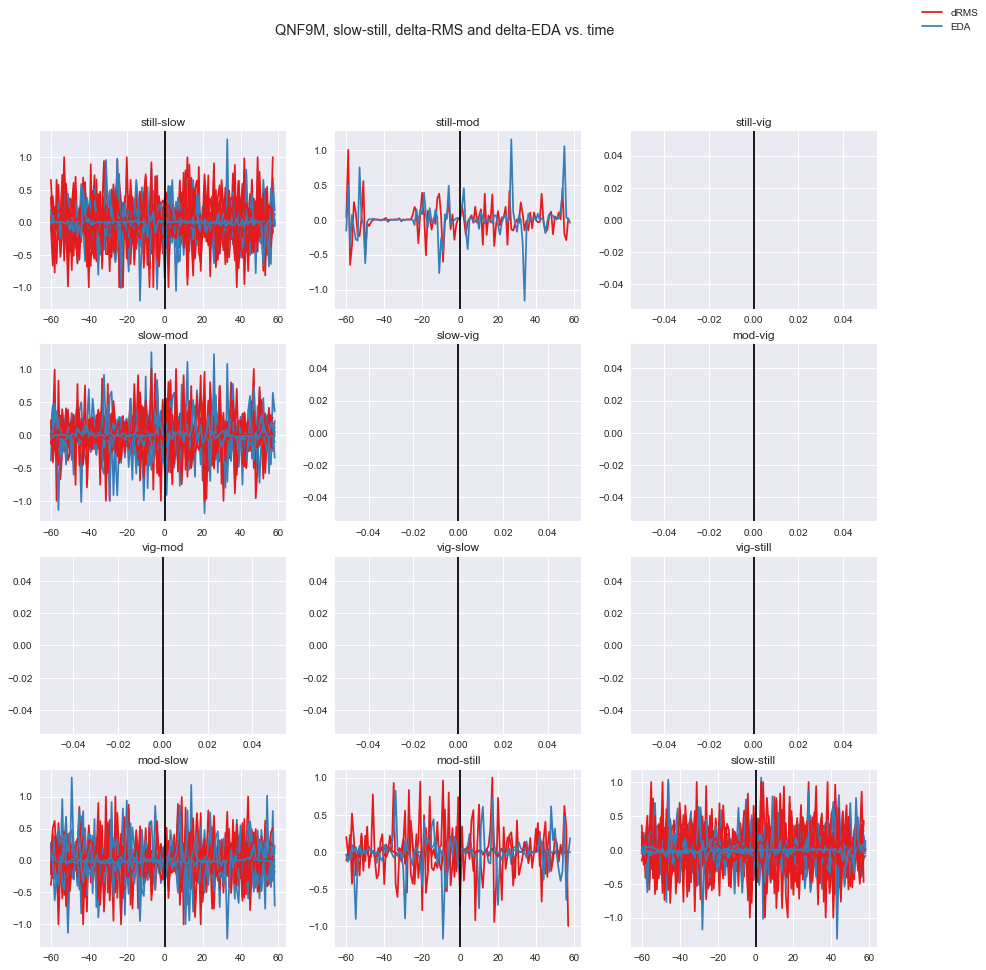

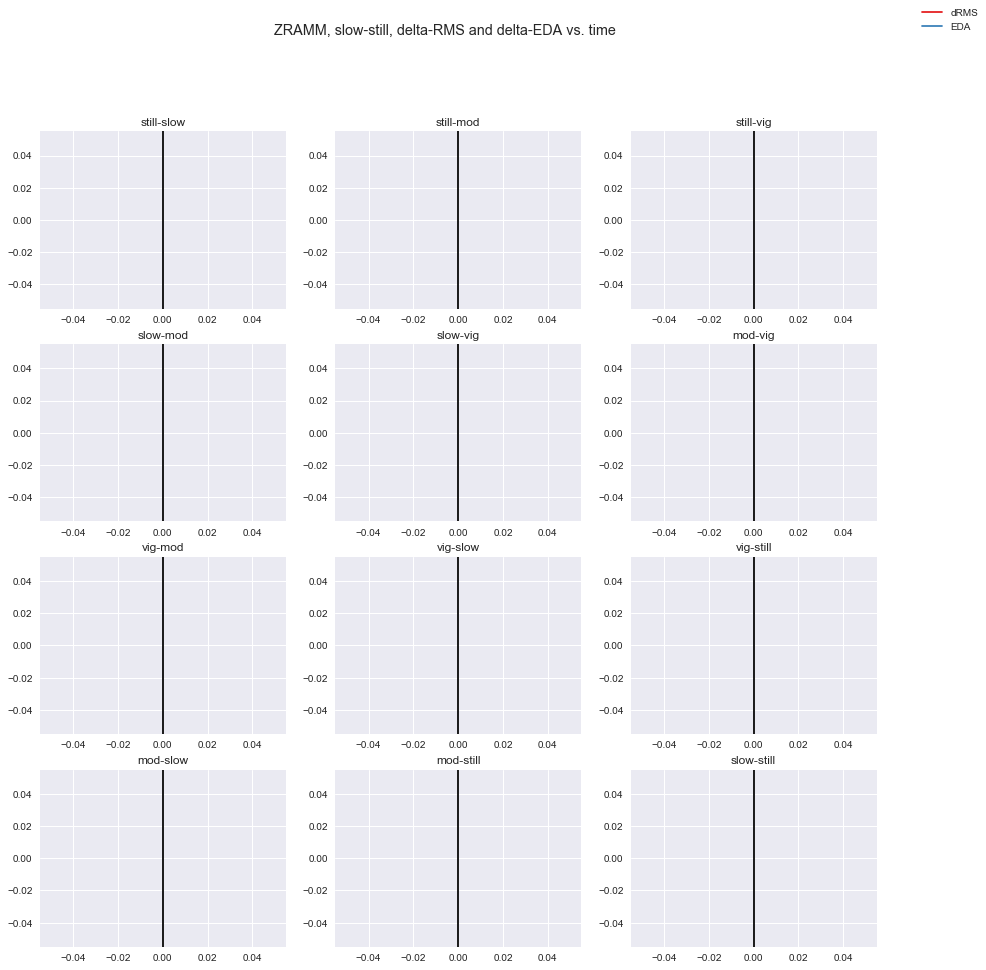

In [45]:
for i in patients:
    a = preprocess(i, frequency)
    process(i, frequency, 60, a[0], a[1], a[2])